In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
import ee
import os
import pandas as pd
import datetime
import geemap
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AWtgzh6mMdGXtdVoP7m0VjDJF7cbU9Yw76jrxSgyD5X-lsOGqhO_f2VpFPo



Successfully saved authorization token.


In [449]:
# Import the Land Surface Temperature
dict_product={'ERA5m':['ECMWF/ERA5_LAND/MONTHLY_AGGR','evaporation_from_open_water_surfaces_excluding_oceans_sum'],'ERA5pp':['ECMWF/ERA5/MONTHLY','total_precipitation']}

# Final date of interest (exclusive).
i_date="1992-04-01"
f_date=str(datetime.date.today().strftime("%Y-%m-%d"))
banda='evaporation_from_open_water_surfaces_excluding_oceans_sum'
scale=11132

names=['EmbSantaJuana','EmbLagunaGrande','EmbLagunaChica']

pointSantaJuana = ee.Feature(ee.Geometry.Point([-70.638152, -28.678163]),{'name':names[0]})
pointLagunaGrande = ee.Feature(ee.Geometry.Point([-69.90601, -28.73146]),{'name':names[1]})
pointLagunaChica = ee.Feature(ee.Geometry.Point([-69.84304, -28.80119]),{'name':names[2]})

features=[pointSantaJuana,pointLagunaGrande,pointLagunaChica]
# final Feature collection assembly
ee_fc = ee.FeatureCollection(features)
ee_fc

In [439]:
def rasterExtraction(image):
    feature = image.sampleRegions(**{'collection':ee_fc,'scale':scale})
    return feature

def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

def gdf2FeatureCollection(gdf):
    features = []
    for i in range(gdf.shape[0]):
        geom = gdf.iloc[i:i+1,:] 
        
        jsonDict = json.loads(geom.to_json())
        x=np.array([x[0] for x in jsonDict['features'][0]['geometry']['coordinates'][0]])
        y=np.array([x[1] for x in jsonDict['features'][0]['geometry']['coordinates'][0]])
        cords = np.dstack((x[:],y[:])).tolist()
        g=ee.Geometry.Polygon(cords).bounds()
        feature = ee.Feature(g,{'name':gdf.loc[i,'Nombre']})
        features.append(feature)
    return ee.FeatureCollection(features)

def main():
    ERA5data = ee.ImageCollection(dict_product.get(list(dict_product.keys())[0])) \
    .filterDate(i_date,f_date).map(addDate)
  
    results=ERA5data.filterBounds(ee_fc).select(banda).map(addDate)\
    .map(rasterExtraction).flatten()
    sample_result=results.first().getInfo()
    #extract the properties column from feature collection
    #column order may not be as out sample data order

    #order data columns as per sample data order
    #You can modify this for better optimizaction
    column_df=['name']
    column_df.extend([banda,'date'])
    nested_list = results.reduceColumns(ee.Reducer.toList(len(column_df)),
                                        column_df).values().get(0)
    data = nested_list.getInfo()
    df = pd.DataFrame(data, columns=column_df)
    df.index=pd.to_datetime(df['date'],format="%Y%m%d")
    df=df[[x for x in df.columns if x!='date']]
    df_pivot=pd.pivot_table(df,values=banda,index=df.index,columns=df['name'])
    print(df_pivot.head())


In [57]:
# pasar a mm/mes
df_pivot_mm=df_pivot*-1000

In [58]:
df_pivot_mm.to_csv(os.path.join('.','EV_mm_'+list(dict_product.keys())[0]+'.csv'))

<AxesSubplot: xlabel='date'>

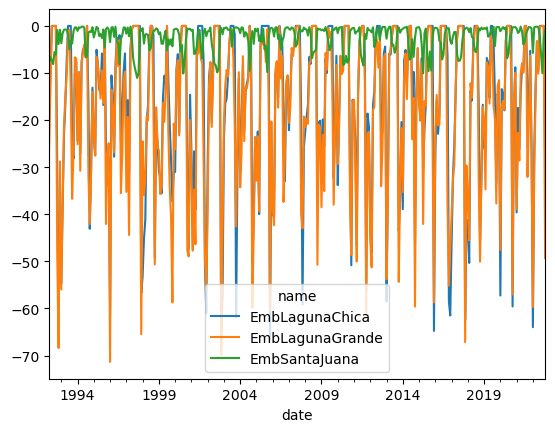

In [56]:
df_pivot_mm.plot()

C:\Users\ccalvo\AppData\Local\Temp\ipykernel_35136\1124893523.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry=gdf.geometry.buffer(0.025)


<AxesSubplot: >

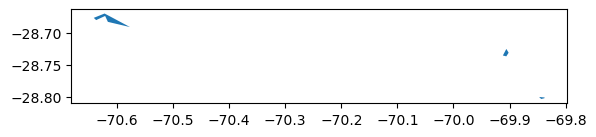

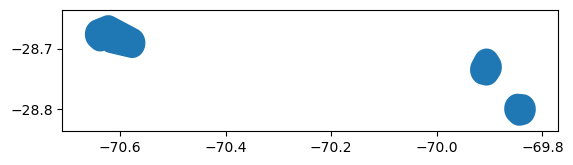

In [469]:
import geopandas as gpd

gdf=gpd.read_file(r'G:\pywrDemo\Huasco\geodata\embalsesFix.shp')
gdf=gpd.GeoDataFrame(gdf,geometry=gdf.simplify(1).geometry)
gdf.set_crs(epsg='4326',inplace=True)
gdf.plot()
gdf.geometry=gdf.geometry.buffer(0.025)
gdf.plot()

In [470]:
import json
import numpy
# convert to FeatureCollection using one line of code
ee_fc=gdf2FeatureCollection(gdf)

In [471]:
banda=dict_product.get(list(dict_product.keys())[1])[1]
ERA5data = ee.ImageCollection(dict_product.get(list(dict_product.keys())[1])[0]) \
    .filterDate(i_date,f_date).map(addDate)
  
results=ERA5data.filterBounds(ee_fc).select(banda).map(addDate)\
.map(rasterExtraction).flatten()
sample_result=results.first().getInfo()
#extract the properties column from feature collection
#column order may not be as out sample data order

#order data columns as per sample data order
#You can modify this for better optimizaction
field='name'
column_df=[field]
column_df.extend([banda,'date'])
nested_list = results.reduceColumns(ee.Reducer.toList(len(column_df)),
                                    column_df).values().get(0)
data = nested_list.getInfo()
df = pd.DataFrame(data, columns=column_df)
df.index=pd.to_datetime(df['date'],format="%Y%m%d")
df=df[[x for x in df.columns if x!='date']]
df_pivot=pd.pivot_table(df,values=banda,index=df.index,columns=df[field])
print(df_pivot.head())

name        Embalse Santa Juana
date                           
1992-04-01             0.024539
1992-05-01             0.030949
1992-06-01             0.026541
1992-07-01             0.010032
1992-08-01             0.011532


In [473]:
df_pivot.to_csv(os.path.join('.','Pp_m_'+list(dict_product.keys())[0]+'.csv'))